1. В коде из методички реализуйте один или несколько критериев останова: количество листьев, количество используемых признаков, глубина дерева итд

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [110]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 6, n_informative = 3, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

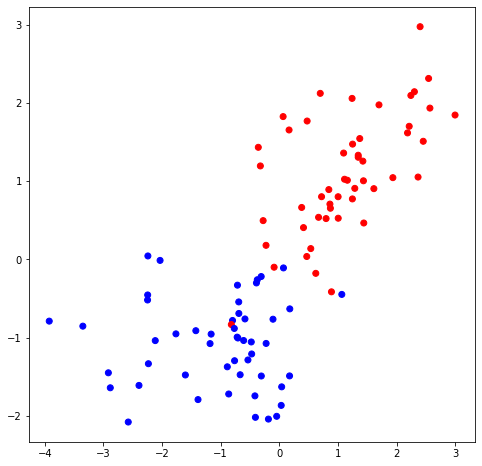

In [111]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [112]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [113]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчёт количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдём класс, количество объектов которого будет максимальным в этом листе, и вернём его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [114]:
# Расчёт критерия Джини

def gini(labels):
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчёт критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределённости
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [115]:
# Расчёт качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [116]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [117]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, где в узле остаётся менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [118]:
# Построение дерева посредством рекурсивной функции
depth = 0

def build_tree(data, labels, set_depth=0, count_of_indexes=0):
    global depth

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай — прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    #Добавил 2 критерия остановки
    if set_depth != 0:
        depth += 1
        if depth > set_depth and depth > 1:
            return Leaf(data, labels)
    
    if count_of_indexes != 0 and count_of_indexes <= index:
        raise f'impossible to present a trait in {index} variations'
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, set_depth=set_depth, count_of_indexes=count_of_indexes)
    false_branch = build_tree(false_data, false_labels, set_depth=set_depth, count_of_indexes=count_of_indexes)
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева

    return Node(index, t, true_branch, false_branch)

In [119]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [120]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [121]:
# Разобьём выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [122]:
#Зададим к примеру глубину 3
my_tree = build_tree(train_data, train_labels, set_depth=3)
my_tree


In [123]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1
Порог 0.042200090658417455
--> True:
  Индекс 0
  Порог 0.17523950797477372
  --> True:
    Индекс 1
    Порог -0.8549291502575771
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 0


In [124]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [125]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [126]:
# Введём функцию подсчёта точности, как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [127]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

94.28571428571428

In [128]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [129]:
from sklearn.metrics import r2_score

# сгенерируем данные
regression_data, regression_labels = datasets.make_regression(n_samples=100, n_features=4, random_state=42)

(array([10., 10., 14., 16., 16., 14., 12.,  4.,  3.,  1.]),
 array([-175.91641581, -130.92406503,  -85.93171426,  -40.93936348,
           4.05298729,   49.04533807,   94.03768884,  139.03003962,
         184.02239039,  229.01474117,  274.00709194]),
 <BarContainer object of 10 artists>)

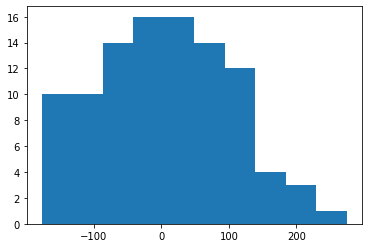

In [130]:
plt.hist(regression_labels)

In [131]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(regression_data, regression_labels, test_size = 0.3, random_state = 1)

In [132]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):    
        return np.mean(self.labels)

In [133]:
# Расчёт критерия Джини

def gini(labels):
    return np.var(labels, ddof=0)
    # return np.mean(labels)

In [134]:
def predict_regression(set_depth = 3):
    my_tree = build_tree(train_data, train_labels, set_depth=set_depth)
    print_tree(my_tree)
    
    train_answers = predict(X_train, my_tree)

    answers = predict(X_test, my_tree)

    train_accuracy = r2_score(y_train, train_answers)
    print(f'Точность на обучающей выборке: {train_accuracy}')

    test_accuracy = r2_score(y_test, answers)
    print(f'Точность на тестовой выборке: {test_accuracy}')

In [135]:
predict_regression(set_depth = 0) # дисперсия

Индекс 1
Порог 0.042200090658417455
--> True:
  Индекс 0
  Порог 0.17523950797477372
  --> True:
    Индекс 1
    Порог -0.8549291502575771
    --> True:
      Прогноз: 1.0
    --> False:
      Индекс 2
      Порог 1.3462104000582982
      --> True:
        Прогноз: 1.0
      --> False:
        Прогноз: 0.6666666666666666
  --> False:
    Прогноз: 0.4
--> False:
  Прогноз: 0.0
Точность на обучающей выборке: -0.006546443510851763
Точность на тестовой выборке: -0.014172380280170538
